# Example Run

This package is meant to be fast, flexible, and have support for novel kinds of inference, which we'll walk through.

The model itself isn't complex. The basic idea is that you pass in the spatial coordinates, and get graphs which are essentially just small patches of tissue. It takes in pairwise distances between all the nodes (which captures all the information about local structure) and information about each cell's identity (typically, some batch corrected latent space from a VAE like scVI). You use a graph transformer on the local structure, pool all the latent representations of all the nodes, and then you try to predict the identity of the center cell of the patch. In learning how to do this, the model learns something about different niches, taking in both structural and cell identity information.

This package should run fast enough so that even for large spatial datasets, you can do the entire run in <20 mins on a laptop.

In [3]:
import scanpy as sc

adata = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/OCT2025/spatial-transformer/models/17OCT2025/adata-cell-leiden.h5ad"
)

In [4]:
import sys
sys.path.append("/home/jhaberbe/Projects/Fun/rapid-niches")

from rapidniches.data import PairwiseGraphBuilder, GraphTransformerHandler
from rapidniches.model import GraphTransformer

### Loading your Dataset

`PairwiseGraphBuilder` takes you cell identities (Typically batch corrected VAE latent representation from a package like scVI), and builds a dataloader. It should take less than a minute, even for large datasets (>>100,000).

In [5]:
# Hacky way to make sure different tissue slides don't overlap.
adata.obs["z_centroid"] = adata.obs["folder"] \
    .replace({k: i * 1000 for i, k in enumerate(adata.obs["folder"].unique())})

# Actual locations, it can be in 2D or 3D
locations = adata.obs[["x_centroid", "y_centroid", "z_centroid"]].values

/tmp/ipykernel_1770209/1335119469.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({k: i * 1000 for i, k in enumerate(adata.obs["folder"].unique())})
/tmp/ipykernel_1770209/1335119469.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace({k: i * 1000 for i, k in enumerate(adata.obs["folder"].unique())})


In [6]:
# build the graphs and the dataloader
pgb = PairwiseGraphBuilder(adata.obsm["X_token"], locations, 20)
dataloader = pgb.create_dataloader(batch_size=512)

100%|██████████| 423530/423530 [00:23<00:00, 17814.08it/s]
/home/jhaberbe/Projects/Fun/rapid-niches/rapidniches/data.py:94: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  return DataLoader(


### Training

Model training is usually pretty fast (between 1-2 minutes). You can use a GPU, though in my hands it didn't really improve inference speed too much. If you get an Out of Memory Error, just reduce the batch size; even with batch sizes of 16 I was able to train this model well. In this example, I'll show CPU inference, to show its pretty fast.

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GraphTransformer()
handler = GraphTransformerHandler(model, device=device)

Actual training doesn't necessarily have to complete a full epoch to get solid results. What matters more is that you train it until it appears to converge, and be willing to wait a while after it appears to converge.

In [8]:
handler.train(dataloader, num_epochs=1)

Epoch 1/1:   0%|          | 0/828 [00:00<?, ?it/s]/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/torch_geometric/data/data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'target', 'X', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/torch_geometric/data/collate.py:142: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'target', 'X', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  repeats = [store.num_nodes or 0 for store in stores]
Epoch 1/1: 100%|██████████| 828/828 [06:54<00:00,  2.00it/s, Batch Loss=6.7883]

Epoch 1 Loss: 7.7784


Looking at the training history, we can see the model converges very quickly and seems to perform consistently across shuffled batches after about 100 epochs.

Final batch loss: 6.788283824920654


<Axes: >

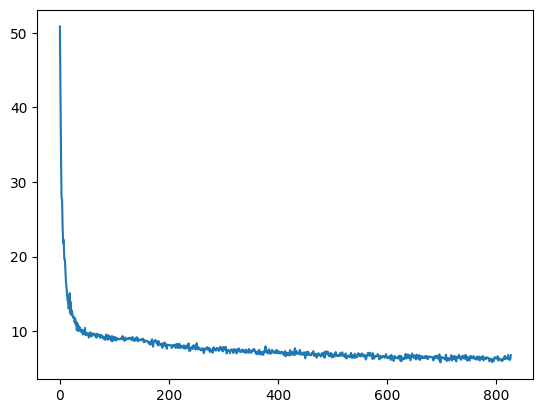

In [9]:
import pandas as pd
# Get training history
history = handler.get_training_history()
print(f"Final batch loss: {history['batch_losses'][-1]}")
pd.Series(history['batch_losses']).plot()

### Reproducibility

Saving the output is very easy.

In [ ]:
# Save the model
handler.save_checkpoint("checkpoint.pth")
handler.save_model("saved_model/")

Checkpoint saved to checkpoint.pth
Model saved to saved_model/


So is loading it 

In [11]:
# Load the model
handler = GraphTransformerHandler.load_model("saved_model/", GraphTransformer)

Model loaded from saved_model/


### Clustering

Getting the latent representation is about as fast as training is. For a dataset of about 400,000 it took about 4 minutes.

In [ ]:
# Get latent representations (graph transformer only)
latent_repr = handler.predict_latent(dataloader)
print(f"Latent representations shape: {latent_repr.shape}")

/home/jhaberbe/Projects/Fun/rapid-niches/rapidniches/data.py:158: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  unshuffled_dataloader = DataLoader(


Using temporary unshuffled dataloader for consistent latent representations


Predicting Latent Representations:   0%|          | 0/828 [00:00<?, ?it/s]/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/torch_geometric/data/data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'target', 'X', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/torch_geometric/data/collate.py:142: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'target', 'X', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  repeats = [store.num_nodes or 0 for store in stores]
Predicting Latent Representations:  43%|████▎     | 356/828 [01:28<01:56,  4.05it/s]

Clustering is done how you might for PCA / scVI coordinates. It takes about as long, if not longer, to generate the UMAPs and clusters as it does to do the actual inference.

In [ ]:
adata.obsm["latent"] = latent_repr
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)
sc.tl.leiden(adata, n_iterations=2, flavor="igraph", resolution=0.2)

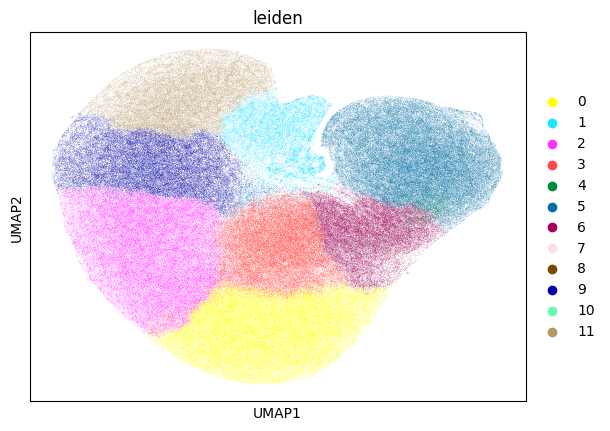

In [19]:
sc.pl.umap(adata, color=["leiden"])

# Additional Batteries

Because of the way its trained, we get some extra inference machinery for free. We use a normalizing flow, so when we pass in a token and the cell context, we actually get information about the log-probability of any given token existing within a particular spatial niche. So, for two different tokens from the same cluster (cell type), with slightly different identities, you can compute the likelihood of finding each of those cells in the same niche, and see whether there are regions where one is significantly more likely than the other, which might give you some interesting information.

For the purpose of this example, I'm going to take two Microglia-PVM cells. One is GPNMB-high, which is a marker for Microglia activation in the context of amyloid pathology in our dataset. We'll compare it against GPNMB-low P2RY12-high Microglia-PVM, which represent homeostatic Microglia-PVM. 

In an ideal scenario, our graph transformer should learn something about the relative probability for these two types of cells given different spatial contexts.